# <center>CS-485 Data Science and Applications</center>
## <center>Assignment 6</center>
### <center>Alexandros Angelakis csdp1363, angelakis@csd.uoc.gr</center>

# Load Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler

# Load dataset
from statsmodels.datasets import sunspots
df = sunspots.load_pandas().data
df.head()

c:\Users\panat\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


,YEAR,SUNACTIVITY
0,1700.0,5.0
1,1701.0,11.0
2,1702.0,16.0
3,1703.0,23.0
4,1704.0,36.0


# ADF Analysis

## is stationary?




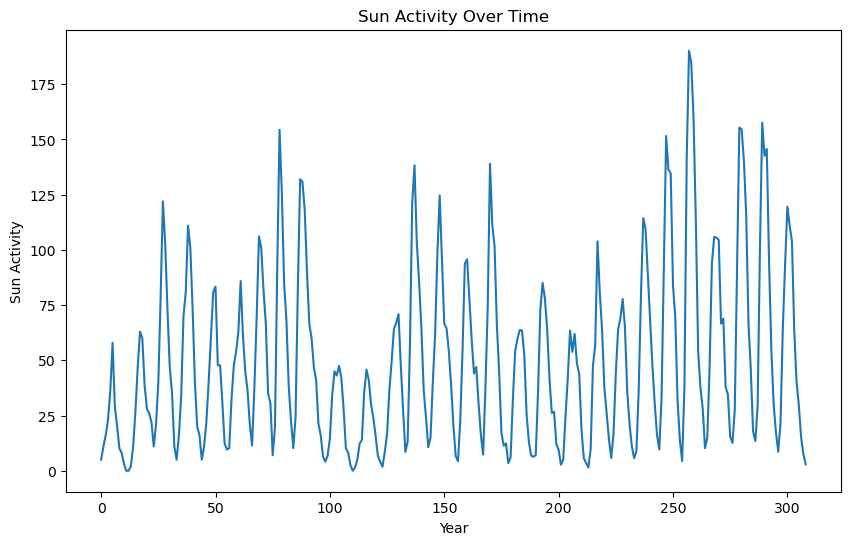

ADF Statistic: -2.8377807249381974
p-value: 0.05307642172812028
Critical Values:
	1%: -3.4523371197407404
	5%: -2.871222860740741
	10%: -2.571929211111111


In [2]:
df = df['SUNACTIVITY']
ts = df

# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(ts)
plt.title('Sun Activity Over Time')
plt.xlabel('Year')
plt.ylabel('Sun Activity')
plt.show()

# Function to check stationarity
def check_stationarity(ts):
    result = adfuller(ts)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')

# Check stationarity
check_stationarity(ts)

### We can see that p is really close to 0.05 and the ADF statistic is not greater than all the critical values at 1%, 5% and 10%. Thus, we reject the null hypothesis and the time series is stationary!

# ACF & PACF


c:\Users\panat\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


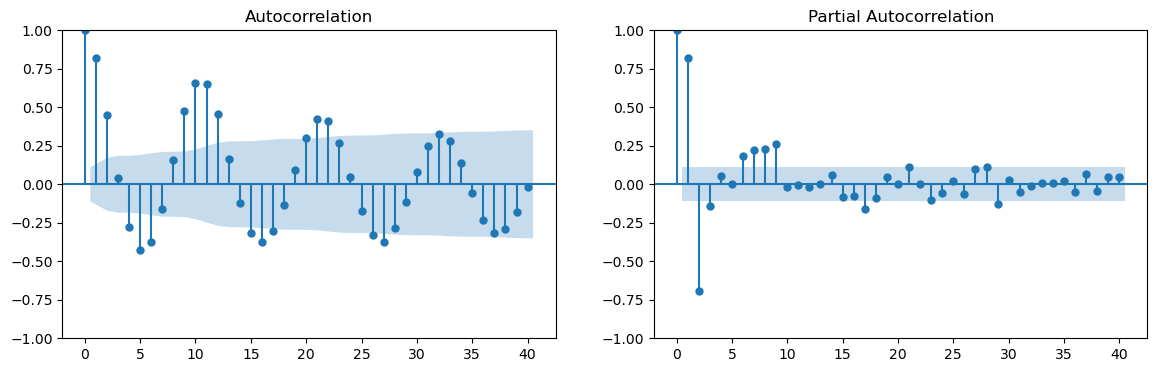

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(df, lags=40, ax=ax1)
plot_pacf(df, lags=40, ax=ax2)
plt.show()

# STL Analysis

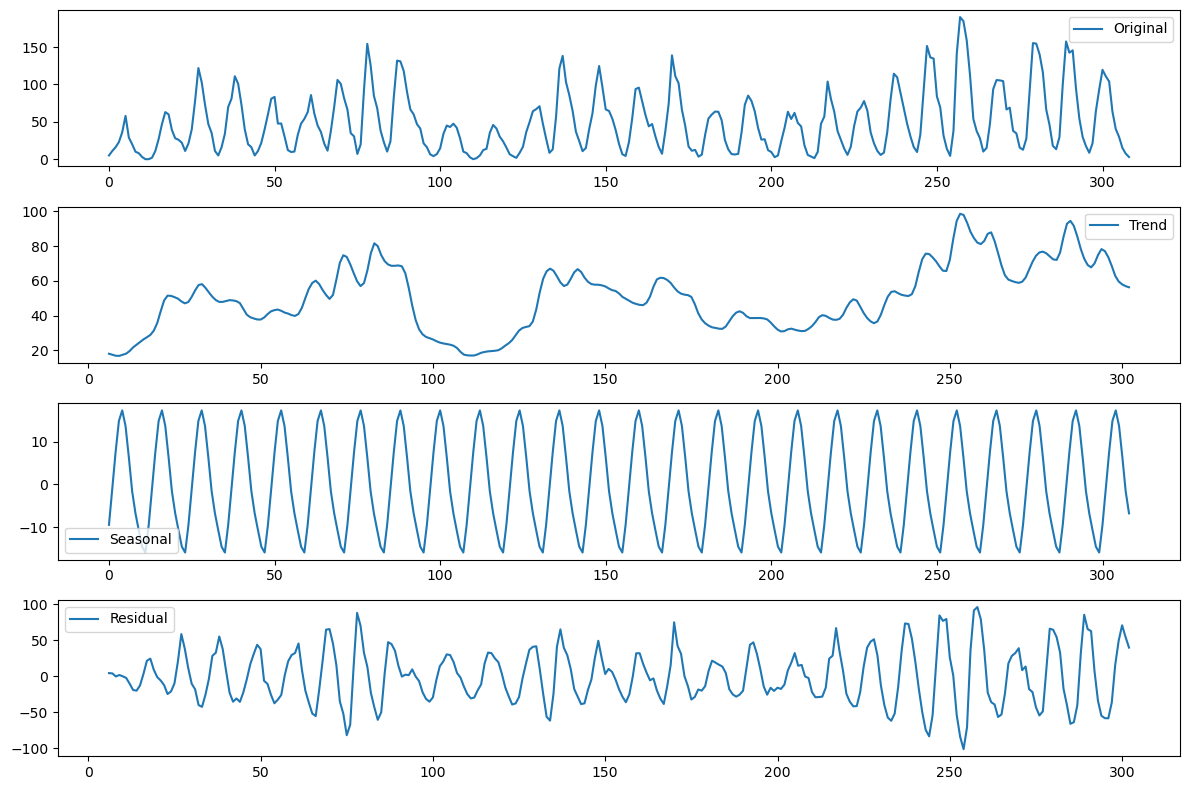

In [4]:
decomposition = seasonal_decompose(ts, model='additive', period=12)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot decomposed components
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# ARIMA Model
## p=2 , because by looking at the PACF plot, we can see that the partial autocorrelation of the series has a significant spike at lag 1 and 2.
## q=6, because by looking at the ACF plot, we can see that the autocorrelation is significant at 6 values of lag (the lag at value 0 represents the correlation of the series with itself, hence not informative).
## d=0, because our time series is stationary. No need to apply any differencing to make the series stationary, as it already exhibits constant statistical properties over time

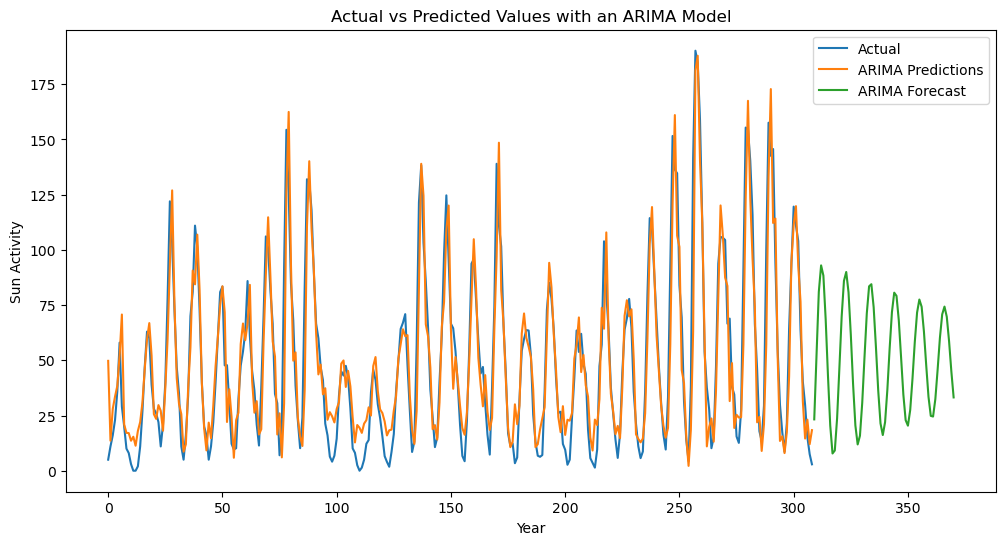

In [5]:
# Train-test split
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Train ARIMA model
arima_model = ARIMA(ts, order=(2, 0, 6)) #(p, d, q)
arima_fitted_model = arima_model.fit()
arima_forecast = arima_fitted_model.forecast(steps=len(test))

# Predictions
pred_arima = arima_fitted_model.predict(dynamic=False)

plt.figure(figsize=(12, 6))
plt.plot(ts, label='Actual')
plt.plot(pred_arima, label='ARIMA Predictions')
plt.plot(arima_forecast, label='ARIMA Forecast')
plt.legend()
plt.title('Actual vs Predicted Values with an ARIMA Model')
plt.xlabel('Year')
plt.ylabel('Sun Activity')
plt.show()
plt.close()

# LSTM Model

c:\Users\panat\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


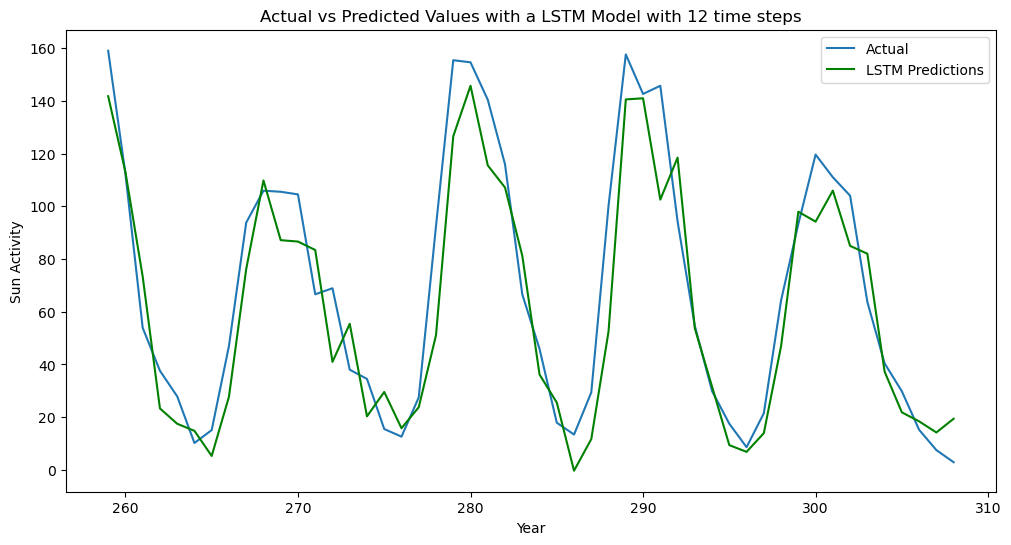

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_normalized = scaler.fit_transform(train.values.reshape(-1, 1))
test_normalized = scaler.transform(test.values.reshape(-1, 1))

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 12
X_train, y_train = create_dataset(train_normalized, train_normalized, time_steps)
X_test, y_test = create_dataset(test_normalized, test_normalized, time_steps)

lstm_model = Sequential()
lstm_model.add(LSTM(units=50, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(Dense(units=1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=200, batch_size=32, verbose=0)

pred_lstm = lstm_model.predict(X_test)
pred_lstm = scaler.inverse_transform(pred_lstm)

plt.figure(figsize=(12, 6))
plt.plot(test.index[time_steps:], ts[test.index[time_steps:]], label='Actual')
plt.plot(test.index[time_steps:], pred_lstm, label='LSTM Predictions', color='green')
plt.legend()
plt.title(f'Actual vs Predicted Values with a LSTM Model with {time_steps} time steps')
plt.xlabel('Year')
plt.ylabel('Sun Activity')
plt.show()
plt.close()

# Simple RNN

c:\Users\panat\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


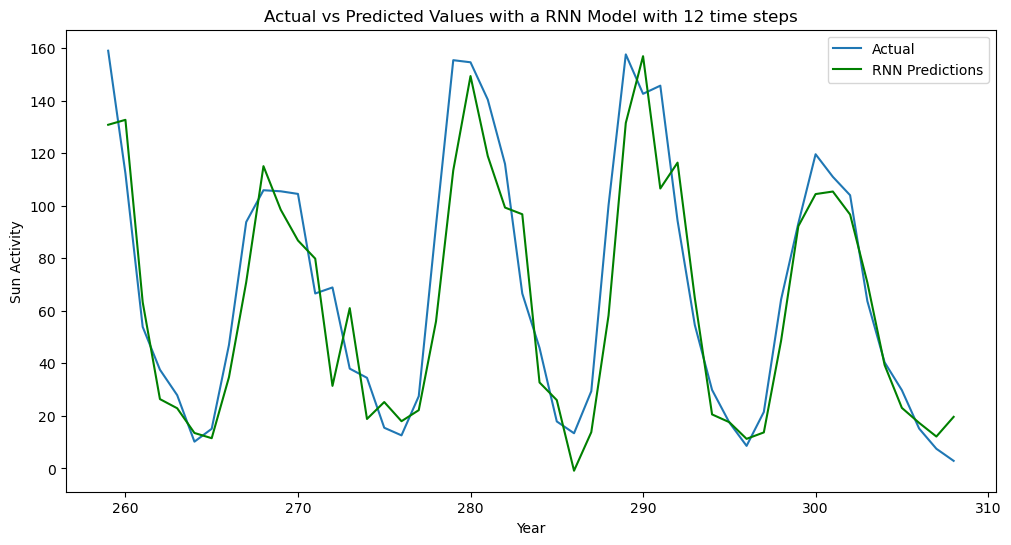

In [7]:
# Train Simple RNN model
rnn_model = Sequential()
rnn_model.add(SimpleRNN(units=50, input_shape=(X_train.shape[1], X_train.shape[2])))
rnn_model.add(Dense(units=1))
rnn_model.compile(optimizer='adam', loss='mean_squared_error')
rnn_model.fit(X_train, y_train, epochs=200, batch_size=32, verbose=0)

pred_rnn = rnn_model.predict(X_test)
pred_rnn = scaler.inverse_transform(pred_rnn)

plt.figure(figsize=(12, 6))
plt.plot(test.index[time_steps:], ts[test.index[time_steps:]], label='Actual')
plt.plot(test.index[time_steps:], pred_rnn, label='RNN Predictions', color='green')
plt.legend()
plt.title(f'Actual vs Predicted Values with a RNN Model with {time_steps} time steps')
plt.xlabel('Year')
plt.ylabel('Sun Activity')
plt.show()
plt.close()

# Plot Actual and Predicted values from all models

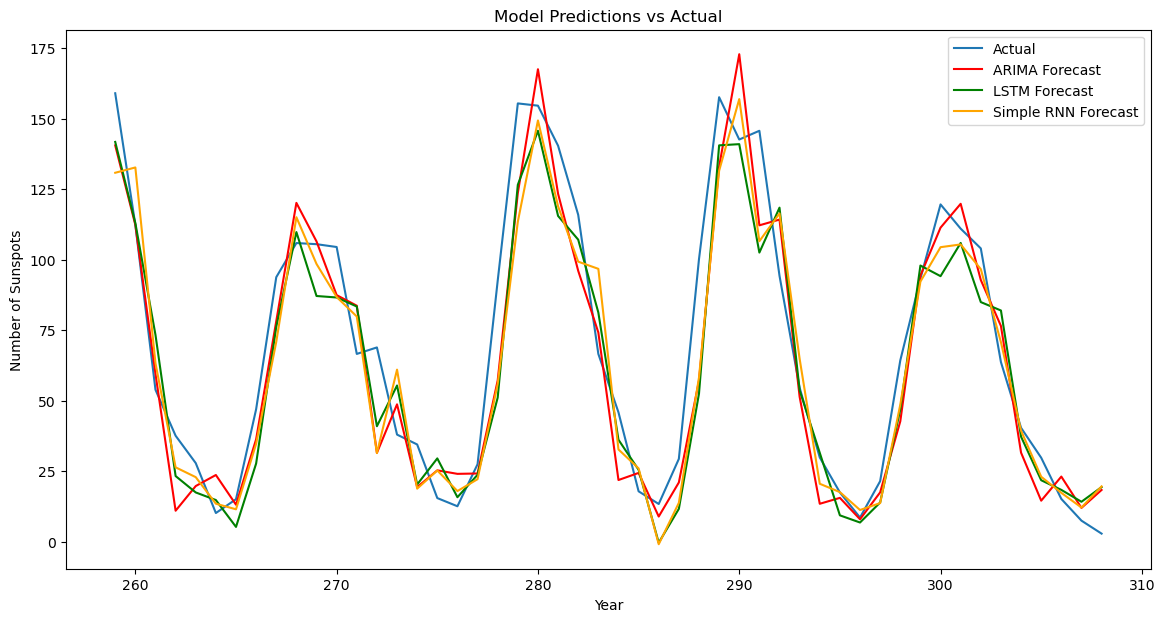

In [8]:
plt.figure(figsize=(14, 7))
plt.plot(test.index[time_steps:], test[test.index[time_steps:]], label='Actual')
plt.plot(test.index[time_steps:], pred_arima[test.index[time_steps:]], label='ARIMA Forecast', color='red')
plt.plot(test.index[time_steps:], pred_lstm, label='LSTM Forecast', color='green')
plt.plot(test.index[time_steps:], pred_rnn, label='Simple RNN Forecast', color='orange')
plt.legend()
plt.title('Model Predictions vs Actual')
plt.xlabel('Year')
plt.ylabel('Number of Sunspots')
plt.show()
plt.close()

# Plot Performance metric for each method

ARIMA Mean Squared Error: 403.48756752417563
LSTM Mean Squared Error: 313.51535281278666
Simple RNN Mean Squared Error: 328.9877655413628


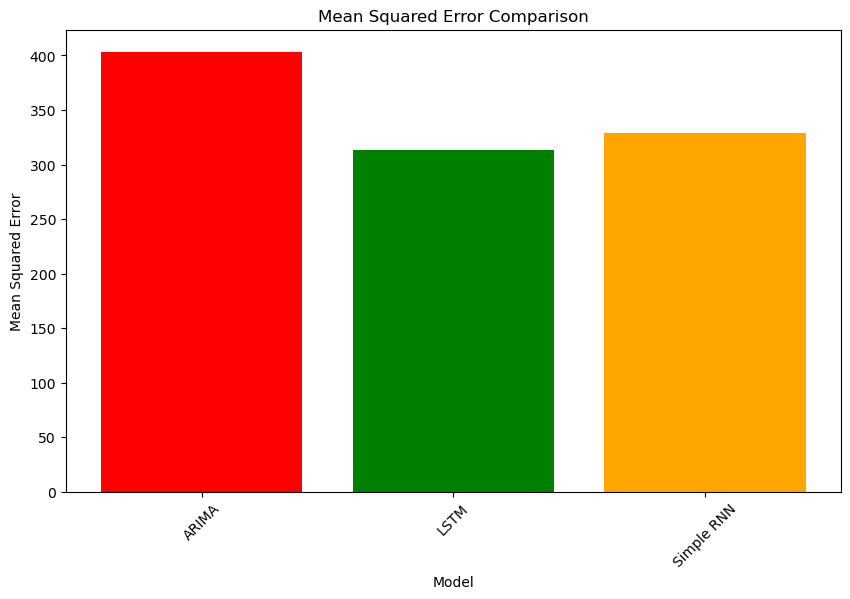

In [9]:
# Evaluate ARIMA model
arima_mse = mean_squared_error(test, pred_arima[test.index])
print('ARIMA Mean Squared Error:', arima_mse)

# Evaluate LSTM model
lstm_mse = mean_squared_error(test[time_steps:], pred_lstm)
print('LSTM Mean Squared Error:', lstm_mse)

# Evaluate Simple RNN model
rnn_mse = mean_squared_error(test[time_steps:], pred_rnn)
print('Simple RNN Mean Squared Error:', rnn_mse)

models = ['ARIMA', 'LSTM', 'Simple RNN']
mse_values = [arima_mse, lstm_mse, rnn_mse]

plt.figure(figsize=(10, 6))
plt.bar(models, mse_values, color=['red', 'green', 'orange'])
plt.title('Mean Squared Error Comparison')
plt.xlabel('Model')
plt.ylabel('Mean Squared Error')
plt.xticks(rotation=45)
plt.show()